In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 15
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'  

In [2]:
U = 22e3

rho = 1e-5
eps0 = 8.854e-12

a = 0.1
b = 0.2
c = 10.0
cfig = 0.5

N_pred = 100

In [14]:
# analytic solution

A = np.array([
    [np.log(a), 1, 0, 0], 
    [0, 0, np.log(c), 1],
    [-np.log(b), -1, np.log(b), 1],
    [-1/b, 0, 1/b, 0]])
B = np.array([U + rho * a**2 / (eps0 * 4), 
              0,               
              - rho * b**2 / (eps0 * 4),
              - rho * b / (eps0 * 2)])

X = np.linalg.solve(A, B)

k11 = X[0]
k12 = X[1]
k21 = X[2]
k22 = X[3]

def phi_fce(r):
    if 0 < r < a:
        voltage = U
        intensity = 0
    elif a <= r < b:
        voltage = - rho / eps0 * r**2 / 4 + k11 * np.log(r) + k12
        intensity = rho / eps0 * r / 2 - k11 / r
    elif b <= r < c:
        voltage = k21 * np.log(r) + k22
        intensity = - k21 / r
    else:
        voltage = 0
        intensity = 0
    
    voltage *= 1e-3
    intensity *= 1e-3
    
    return [voltage, intensity]

In [15]:
# fine division for function plot without DOE
r_fine = np.linspace(a, cfig, 1000)
phi_fine = []
e_fine = []
for x in r_fine:    
    [voltage, intensity] = phi_fce(x)
    phi_fine.append(voltage)
    e_fine.append(intensity)

In [16]:
parameters = [{'name': 'x_1', 'initial_value': b, 'bounds': [a, cfig]}]

r = [(cfig+a)/3, (cfig+a)/3*2]
[phi1, e1] = phi_fce(r[0])
[phi2, e2] = phi_fce(r[1])

phi = [phi1, phi2]
e = [e1, e2]

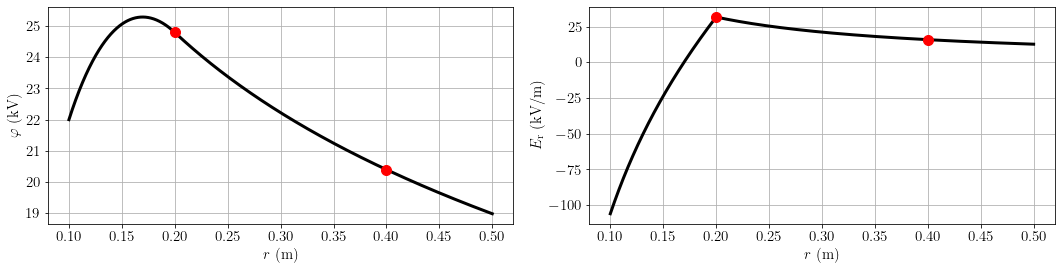

In [17]:
plt.subplot(1,2,1)
plt.plot(r_fine, phi_fine, 'k', linewidth=3)
plt.plot(r, phi, 'or', markersize=10)
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$\\varphi$ (kV)')
plt.grid(True)       
# plt.ylim([0, 8])

plt.subplot(1,2,2)
plt.plot(r_fine, e_fine, 'k', linewidth=3)
plt.plot(r, e, 'or', markersize=10)
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       

plt.tight_layout()
plt.show()

In [18]:
# prediction
r_pred = np.linspace(a, cfig, N_pred)
phi_pred = []
e_pred = []
for x in r_pred:    
    [voltage, intensity] = phi_fce(x)
    phi_pred.append([voltage])
    e_pred.append([intensity])

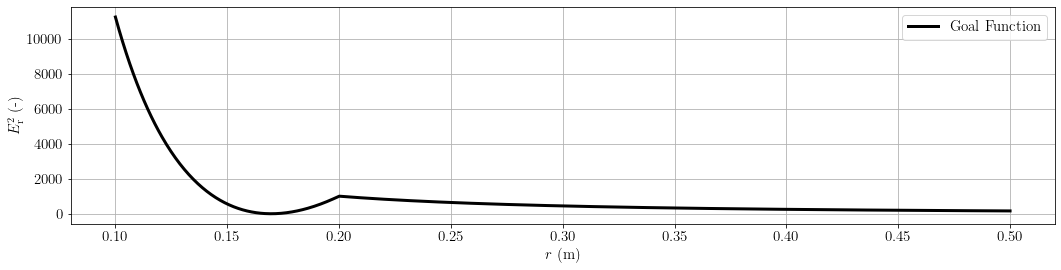

In [19]:
# goal function
e_fine_goal = []
for e_local in e_fine:
    e_fine_goal.append(e_local**2)    

plt.rcParams['figure.figsize'] = (15, 4)
plt.plot(r_fine, e_fine_goal, 'k', linewidth=3, label='Goal Function')
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}^2$ (-)')
#plt.xlim([0.15, 0.18])
#plt.ylim([-15, 5])
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# scikit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, WhiteKernel, ConstantKernel, RationalQuadratic, ExpSineSquared

In [21]:
# adaptive DoE
from artap.problem import Problem
from artap.results import Results
from artap.algorithm_nlopt import NLopt
from artap.algorithm_nlopt import LN_BOBYQA, GN_MLSL, GN_CRS2_LM, GN_ISRES
from artap.algorithm_genetic import NSGAII
    
regressor = GaussianProcessRegressor(kernel=RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)), n_restarts_optimizer=9)

In [26]:
def fce_plot(pred, sigma, r, e):
    plt.subplot(1,2,1)
    plt.plot(r_pred, pred, label='Gaussian Process (scikit)')
    plt.plot(r_fine, e_fine, 'k', linewidth=3, label='Exact Solution')
    plt.plot(r, e, 'or', markersize=10, label="DoE sampling")

    k = abs((max(e_pred)[0]-min(e_pred)[0])) * 2
    plt.fill(np.concatenate([r_pred, r_pred[::-1]]),
             np.concatenate([pred - k * sigma,
                            (pred + k * sigma)[::-1]]),
             alpha=.2, fc='b', ec='None', label='confidence interval')

    plt.ylim([-120, 120])
    plt.grid(True)
    plt.xlabel('$r$ (m)')
    plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
    plt.grid(True)       
    plt.legend()    
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(r_pred, e_pred-np.array([[x] for x in pred]), label='Gaussian Process (scikit)')
    plt.ylim([-10, 10])
    plt.grid(True)
    plt.xlabel('$r$ (m)')
    plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
    plt.grid(True)       
    plt.legend()    
    
    plt.tight_layout()    
    plt.show()

In [27]:
# prediction
def make_pred(r, e):
    regressor.fit(np.array(r).reshape(-1, 1), np.array(e))     
    pred, sigma = regressor.predict(np.array(r_pred).reshape(-1, 1), return_std=True)

    return [pred, sigma]

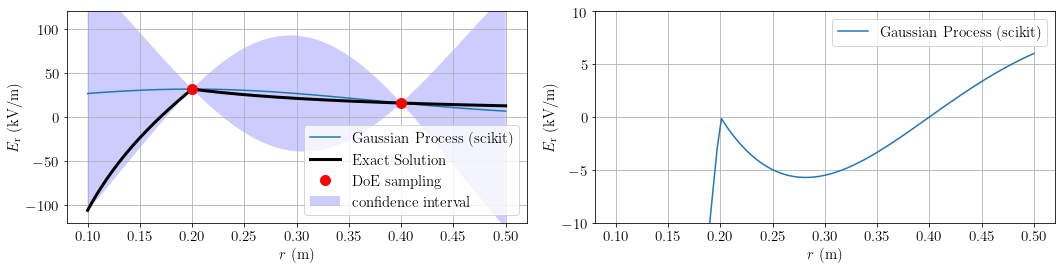

The point with the largest uncertainty: r = 0.5, sigma = 0.48326698756016984, diff_gp_abs = 35.73205078241209


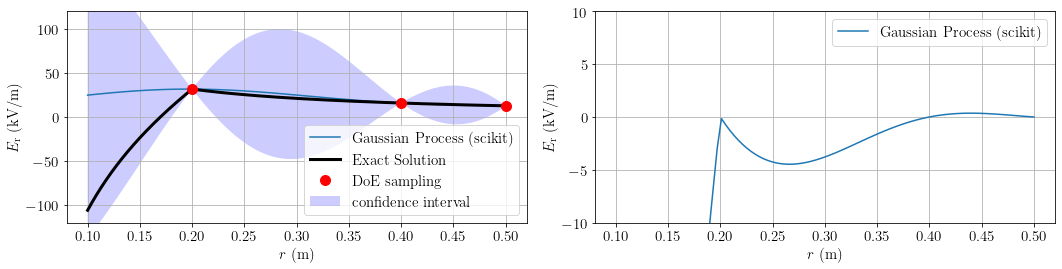

The point with the largest uncertainty: r = 0.1, sigma = 0.5929664989127765, diff_gp_abs = 35.20815566698468


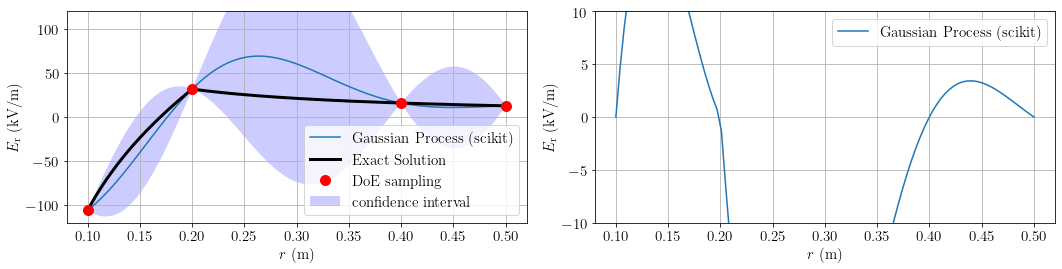

The point with the largest uncertainty: r = 0.302020202020202, sigma = 0.48747051211466585, diff_gp_abs = 22.147420937018566


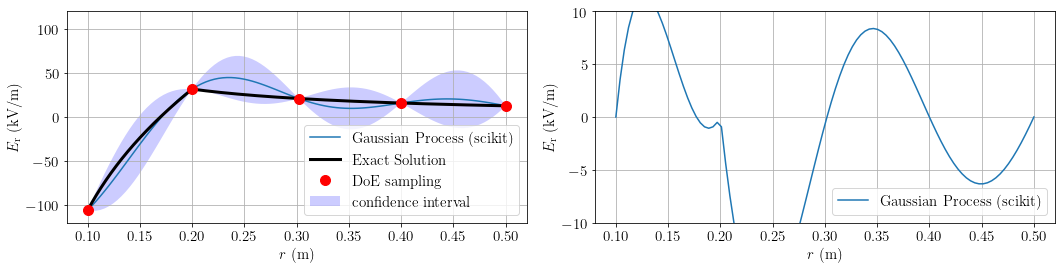

The point with the largest uncertainty: r = 0.14444444444444446, sigma = 0.12107799987714557, diff_gp_abs = 8.176189371973589


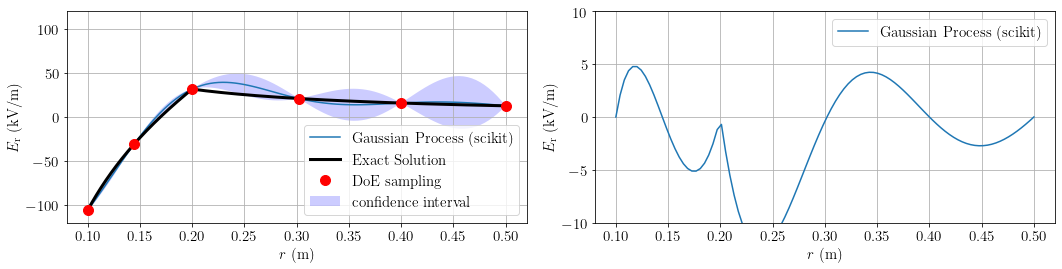

The point with the largest uncertainty: r = 0.4555555555555556, sigma = 0.10869854912359686, diff_gp_abs = 4.97029158237751


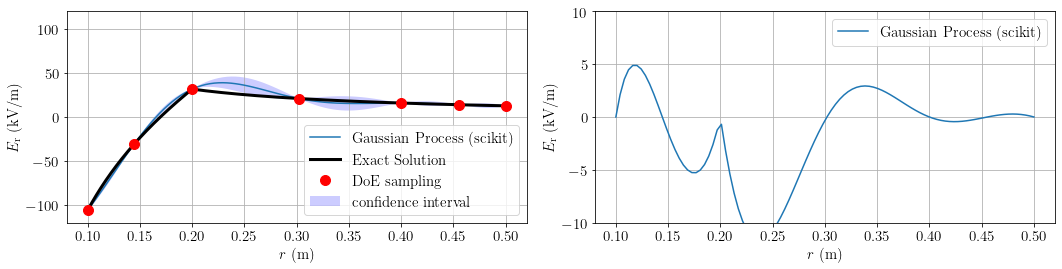

The point with the largest uncertainty: r = 0.2535353535353535, sigma = 0.032145751304868034, diff_gp_abs = 4.547795101144472


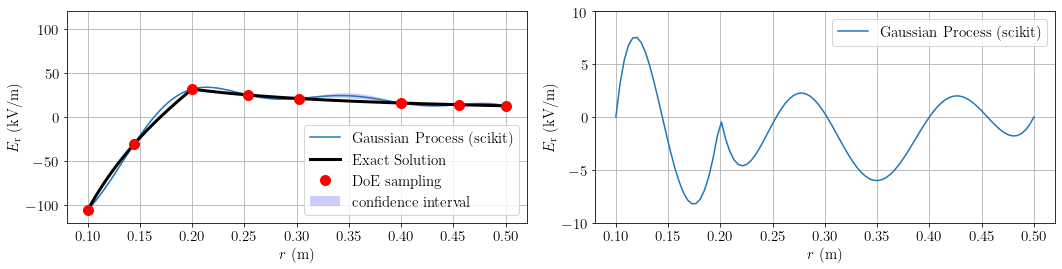

The point with the largest uncertainty: r = 0.3545454545454545, sigma = 0.010656156153981026, diff_gp_abs = 3.797443088021857


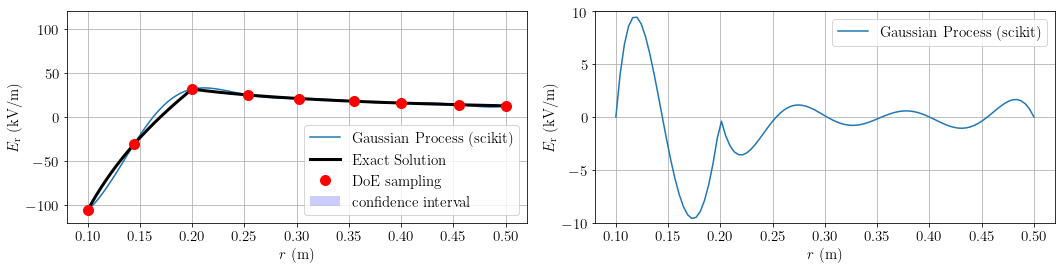

The point with the largest uncertainty: r = 0.11616161616161616, sigma = 0.0034718701279238713, diff_gp_abs = 3.5839114540236774


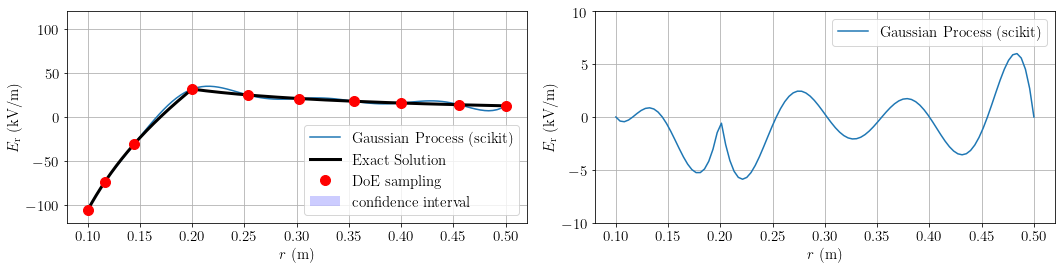

The point with the largest uncertainty: r = 0.48383838383838385, sigma = 0.0027537677242761363, diff_gp_abs = 2.7928996157580186


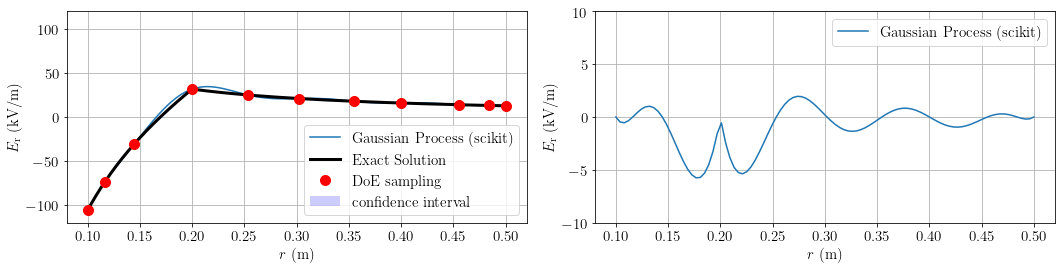

The point with the largest uncertainty: r = 0.17272727272727273, sigma = 0.0002833294307081599, diff_gp_abs = 2.136759594180456


/opt/jupyterhub/env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


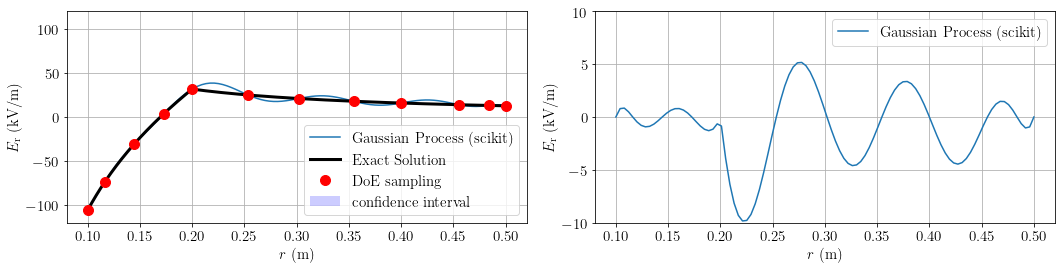

The point with the largest uncertainty: r = 0.42727272727272725, sigma = 0.0001585328180600829, diff_gp_abs = 3.4173486354460487


/opt/jupyterhub/env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


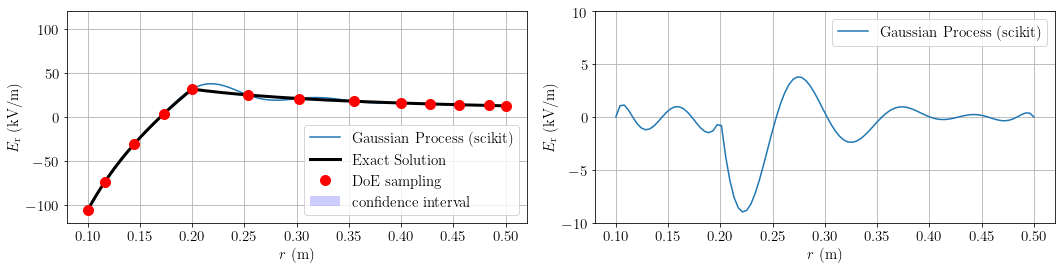

The point with the largest uncertainty: r = 0.39494949494949494, sigma = 0.00014510467143826204, diff_gp_abs = 2.60189276019213


/opt/jupyterhub/env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


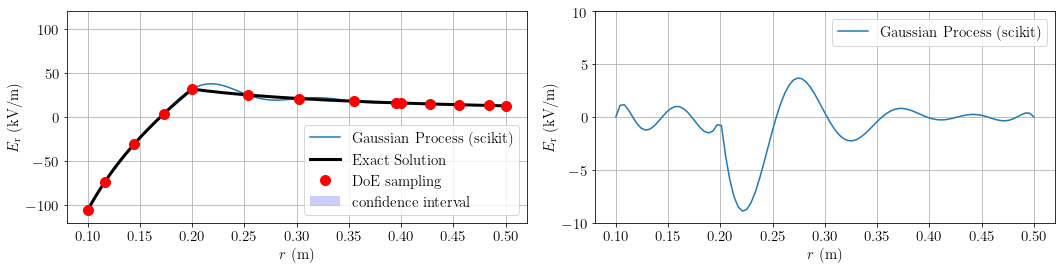

The point with the largest uncertainty: r = 0.398989898989899, sigma = 0.000991638691444563, diff_gp_abs = 2.561942923564101


/opt/jupyterhub/env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


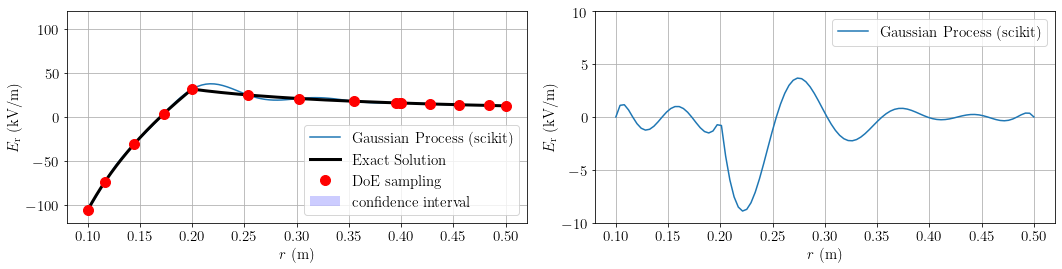

The point with the largest uncertainty: r = 0.4797979797979798, sigma = 0.0008739567723267368, diff_gp_abs = 2.5607172131859555


/opt/jupyterhub/env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


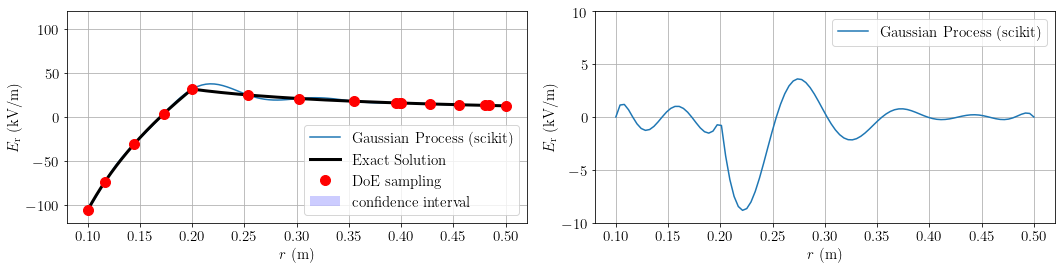

The point with the largest uncertainty: r = 0.37070707070707076, sigma = 0.0011520170672028067, diff_gp_abs = 2.5329892604649102


In [37]:
# copy
r_tmp = r.copy()
e_tmp = e.copy()
# print(r_tmp, e_tmp)

N_doe = 15
for idx in range(N_doe):
    [pred, sigma] = make_pred(r_tmp, e_tmp)
    fce_plot(pred, sigma, r_tmp, e_tmp)

    index_max_val = np.argmax(sigma)    
    r_new = r_pred[index_max_val]

    # quadratic deviation of the solution
    diff_gp = 0
    for i in range(len(r_pred)):
        gp = regressor.predict(np.array(r_pred[i]).reshape(-1, 1), return_std=False)
        diff_gp += ((e_pred[i]-gp))**2
    diff_gp /= len(r_pred)
    diff_gp_abs = np.sqrt(diff_gp)[0]
    print("The point with the largest uncertainty: r = {}, sigma = {}, diff_gp_abs = {}".format(r_new, sigma[index_max_val], diff_gp_abs))

    r_tmp.append(r_new)
    [potential, intensity] = phi_fce(r_new)
    e_tmp.append(intensity)    